# Прогнозирование оттока клиентов для оператора связи

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных.\
Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.\
Информация о договорах актуальна на 1 февраля 2020.

# Цель проекта

Построить модель, которая поможет выявлять клиентов потенциально готовых отказаться от услуг компании.

# План проекта

1. Ознакомление с данными.
* Изучить описание проекта, ознакомиться с поставленной задачей.
* Ознакомиться с предоставленными данными.
* Уточнить желаемый результат и критерии оценки качества. 
* Составить предварительный план проекта.
2. Анализ и предобработка данных.
* Изучить данные и проверить на наличе пропусков, дубликатов, несоотвтетсвие типов данных.
* Изучить и выделить признаки, обозначить целевой признак.
* Провести разделение датасета на выборки.
* Проанализировать данные на предмет дисбаланса. Выбрать методы кодировки для категориальных признаков.
3. Обучение моделей.
* Выбрать несколько моделей для обучения.
* Провести подбор гиперпараметров и обучить модели с замерами требуемых метрик качества.
* Сравнить полученные результаты и выбрать модель с наилучшими показателями.
4. Проверка модели на тестовой выборке.
* Провести проверку выбранной модели на тестовой выборке.
* Проанализировать полученные результаты.
* Сформулировать общий вывод по проделанной работе.
5. Составить отчет о проделанной работе

# Основные требования к проекту

* Использовать параметр RANDOM_STATE = 240423
* Размер тестовой выборки: test_size = 0.25
* В качестве основной метрики необходимо использовать AUC-ROC
* В качестве дополнительной метрики необходимо использовать accuracy

## Ознакомление с данными

In [1]:
# Установка библиотек
!pip install -q skimpy
!pip install -q phik
!pip install -q -U scikit-learn==1.1.3

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from skimpy import clean_columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# Параметры
RND = 240423

In [3]:
# Загрузка данных
contract_df = pd.read_csv('/datasets/contract_new.csv', parse_dates=[1])
personal_df = pd.read_csv('/datasets/personal_new.csv')
internet_df = pd.read_csv('/datasets/internet_new.csv')
phone_df = pd.read_csv('/datasets/phone_new.csv')

In [4]:
# Функция для вывода основных сведений о датасетах
def info(df):
    display(df.shape)
    display(df.head(10))
    display(df.info())

In [5]:
# contract_new.csv
info(contract_df)

(7043, 8)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

В файле contract_new.csv содержится базовая информация о взаимодействии клиента с оператором.
Датасет состоит из 8 столбцов и 7043 строк, не имеет пропусков, однако сразу можно заметить не соответствие типов данных с содержимым.
* customerID - уникальный идентефикатор пользователя, предполагаю, что этот столбец должен быть во всех таблицах и используется для связи конктретного пользователя с хранящимися данными.
* BeginDate - Дата заключения контракта. Тип надо заменить на дату.
* EndDate - Дата окончания контракта. Содержит в себе либо дату (если контракт закрыт), либо значение No, если контракт еще действует. Тип надо заменить на дату. Похоже эту информацию будем использовать для формирования целевого признака.
* Type - В этом столбце содержится информация о типе оплаты ежемесячно или раз в год и т.п.
* PaperlessBilling - Использует ли клиент безналичный расчет.
* PaymentMethod - Метод оплаты.
* MonthlyCharges - Сумма ежемесячного платежа клиента.
* TotalCharges - Сумма всех платежей клиента. Тип не соответсвует данным.

In [6]:
# personal_new.csv
info(personal_df)

(7043, 5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

В файле personal_new.csv содержится некоторая персональная информация клиентов. Количество строк 7043, такое же как в основном датасете, количество столбцов 5.
* customerID - Идентефикатор пользователя.
* gender - Пол клиента.
* SeniorCitizen - Этот столбец обозначает является ли клиент пенсионером, очевидно что содержимое предполагает значения да и нет, выполнено в виде 0 и 1 с типом данных int. 
* Partner - Здесь речь идет о браке, женат или замужем, так же преполагает только два значения Да и Нет.
* Dependents - Имеются ли иждивенцы, полезно было бы знать о их количестве, однако тут значения подразумевает только есть они или нет. Три последних столбца следует привести к единому виду при выполнении предобработки.

In [7]:
# internet_new.csv
info(internet_df)

(5517, 8)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

В файле internet_new.csv мы видим информацию о типе подключенного интернета и дополнительных опциях.
Количество строк составляет 5517, что меньше чем в основном датасете, следовательно не все клиенты компании пользуются интернетом.
Сама суть дополнительных опций для нас скорее всего не столь важна, возможно стоит проверить зависимость от количества подключенных дополнительных услуг. 
В целом можно выделить как признак тип соединения: медленный ADSL или быстрое оптоволокно вполне могут влиять на отток клиентов, как и общее количество дополнительных опций.
Расписывать подробно про содержимое столбцов вероятно не имеет особого смысла.

In [8]:
# phone_new.csv
info(phone_df)

(6361, 2)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Файл phone_new.csv содержит информацию, кто из клиентов имеющих телефон пользуется несколькими линиями связи. Количество строк 6361, что говорит о том, что не каждый клиент компании, пользуется телефоном. Но благодаря этому датасету мы знаем их количество.

# Вывод блока "Ознакомление с данными"

Поставлена задача по исходным данным прогнозировать клиентов, которые намерены отказаться от услуг оператора. 

Изучив данные, мы получили представление о том с чем придется работать. Вероятнее всего все датасеты будет удобнее объединить в один по столбцу customerID и продолжить работать уже с цельным датасетом. При помощи столбцов дата заключения контракта и дата окончания контракта, мы сможем выделить целевой признак. Часть столбцов имеет неверный тип данных и неединообразный вид, следует исправить это в блоке "Предобработка данных", так же озадачиться тем, как оптимальным образом сформировать всю имеющуюся информацию в удобные для обучения признаки, а так же разобраться с дисбалансами и кодированием категориальных признаков.

Так же были уточнены важные критерии для оценки качества модели и значения глобальных параметров, а именно:

* Использовать параметр RANDOM_STATE = 240423
* Размер тестовой выборки: test_size = 0.25
* В качестве основной метрики необходимо использовать AUC-ROC
* В качестве дополнительной метрики необходимо использовать accuracy

Предварительный план составлен, однако в ходе работы возможно будут корректировки, так как учесть все заранее довольно сложно.

## Анализ и предобработка данных

### Предобработка данных

#### Объединение данных

Для удобства, объеденим все датасеты в один.

In [9]:
# Сохраним базовый датасет в отдельную переменную в которой будем сохранять все датасеты
df = contract_df 
# Создадим список датасетов которые нужно присоединить
df_merge_list = [personal_df, internet_df, phone_df]
# При помощи цикла законнектим датасеты из списка по столбцу "customerID"
for d in df_merge_list:
    df = df.merge(d, how='left', on='customerID');

#### Заголовки

Заголовки в целом имеют неплохой и работоспособный вид, но мы сделаем их более наглядными и единообразными.

In [10]:
df = clean_columns(df)
# Обозначим "customerID" как индекс
df.set_index('customer_id', inplace=True)
df.info()

19 column names have been cleaned

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

#### Пропуски и приведение к корректным типам данных

begin_date я преобразовал при сохранении в переменную, а вот end_date кроме дат содержит значение "No" с ним не прокатило,
поэтому сперва надо заменить его на какую-нибудь дату, например на последнюю актуальную дату в датасете.
Клиентов расторгнувших договор на эту дату нет, а при расчете срока действия договора это значение позволит получить адекватные цифры.

In [11]:
df['end_date'] = df['end_date'].replace(['No'], ['2020-02-01'])
# Теперь можно привести столбец к нужному типу данных
df['end_date'] = pd.to_datetime(df['end_date'])

Столбец "total_charges" стоит привести к типу float, однако с этим могут быть проблемы для клиентов,
которые не успели совершить ни одного платежа, пропусков в этом столбце не видно, но пустые значения есть.
В целом клиенты, которые только подключились не дают нам полезной информации для предсказания,
Эти строки следует исключить из датасета, к тому же их немного

In [12]:
display(df.loc[df['begin_date']=='2020-02-01'])
# Воспользуемся pd.to_numeric для преобразования в числовой формат, некорректные значения заменим на NaN
df['total_charges'] = pd.to_numeric(df['total_charges'], errors ='coerce')
df.dropna(subset=['total_charges'], inplace=True)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Теперь для удобства составим список категориальных признаков

In [13]:
cat_list = ['type', 'paperless_billing', 'payment_method', 'gender', 
            'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
           'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

Столбец 'senior_citizen' сообщает о том является ли клиент пенсионером или нет, значения представлены 0 и 1,
Прочие столбцы имеют значения Yes и No, приведем данные к единообразию, для лучшей визуализации при анализе.

In [14]:
print('До обработки\n', df['senior_citizen'].value_counts())
df["senior_citizen"] = np.where(df["senior_citizen"] == 0, 'No', 'Yes')
print('После обработки\n', df['senior_citizen'].value_counts())

До обработки
 0    5890
1    1142
Name: senior_citizen, dtype: int64
После обработки
 No     5890
Yes    1142
Name: senior_citizen, dtype: int64


После объединения датасетов, пользователи не пользующиеся какими-либо услугами или опциями,
получили в соответствующей ячейке значение NaN, первое что следует сделать это заменить его на "No"
Кроме этого полезно будет изменить тип данных на 'category'

In [15]:
for c in cat_list:
    df[c] = df[c].fillna('No').astype('category')

#### Признаки

Целевой признак определяется событием, является ли клиент действующим или расторгнул договор. Эту информацию содержит столбец "end_date". Так как ранее мы заменили очевидное "No" на последнюю актуальную дату, то получается что эта дата и подтверждает, что клиент действующий, все отличные от этого значения даты, говорят о том, что клиент расторгнул договор. Создадим отдельный столбец для хранения этих значений.

In [16]:
# Выделим целевой признак
df['target'] = (df['end_date'] != '2020-02-01').astype(int)
# Для удобстав визуализации, присвоим тектосвые значения
df["target"] = np.where(df["target"] == 0, 'Действующий договор', 'Договор расторгнут')

Неплохо было бы понимать, насколько долго клиент пользуется услугами оператора, чтобы посмотреть есть ли связь. 
Все договора заключаются и расторгаются почему-то первого числа месяца, ̶в̶ ̶м̶е̶с̶я̶ц̶а̶х̶ 
(переделал на дни, от месяцев метрика страдал) и посчитаем период сотрудничества.

In [17]:
df['period'] = (df['end_date'] - df['begin_date']).astype(int)

Пользователям интернет подключения, предоставляют несколько дополнительных опций, 
Я думаю, что было бы неплохо проверить влияние не только каждой опции по отдельности, но и в совокупности.
Для этого создадим отдельный столбец где отобразим суммарное количество дополнительных опций для каждого клиента.

In [18]:
option_list = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df['options']= df.loc[:, option_list].eq("Yes").sum(axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   category      
 3   paperless_billing  7032 non-null   category      
 4   payment_method     7032 non-null   category      
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   category      
 8   senior_citizen     7032 non-null   category      
 9   partner            7032 non-null   category      
 10  dependents         7032 non-null   category      
 11  internet_service   7032 non-null   category      
 12  online_security    7032 non-null   category      
 13  online_backup      7032 non-null   category      
 14

### Анализ данных

In [20]:
# Функции для построения графиков количественных данных
def chart (value, title):
    plt.title(title, fontsize=13)
    sns.kdeplot(value, shade=True, hue=df['target'], alpha=0.5)
    plt.xlim(0)
    plt.xlabel('Величина значений')
    plt.ylabel('Количество значений') 
    return

# Функции для построения графиков категориальных данных
def chart_cat_1 (value, title):
    plt.title(title, fontsize=13)
    sns.histplot(df, x=value, hue="target", multiple="stack",legend=None)
    #plt.xlim(0)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=11, rotation=25)
    return

#### Распределение значений целевого признака

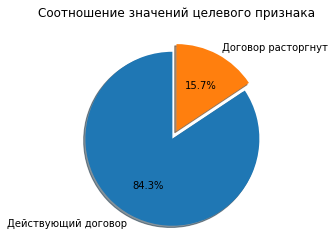

In [21]:
# Распределение целевого признака
df['target'].value_counts().plot(
    ylabel='', 
    kind='pie', 
    explode = (0.1, 0),
    grid=True, 
    title='Соотношение значений целевого признака',
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90);

Присутствует дисбаланс, в каких-то моделях это имеет значение, в каких-то нет. Поэтому работу с ним буду проводить по мере необходимости. Но сам факт зафиксирован.

#### Распределение значений количественных данных, изучение их связи с целевым признаком

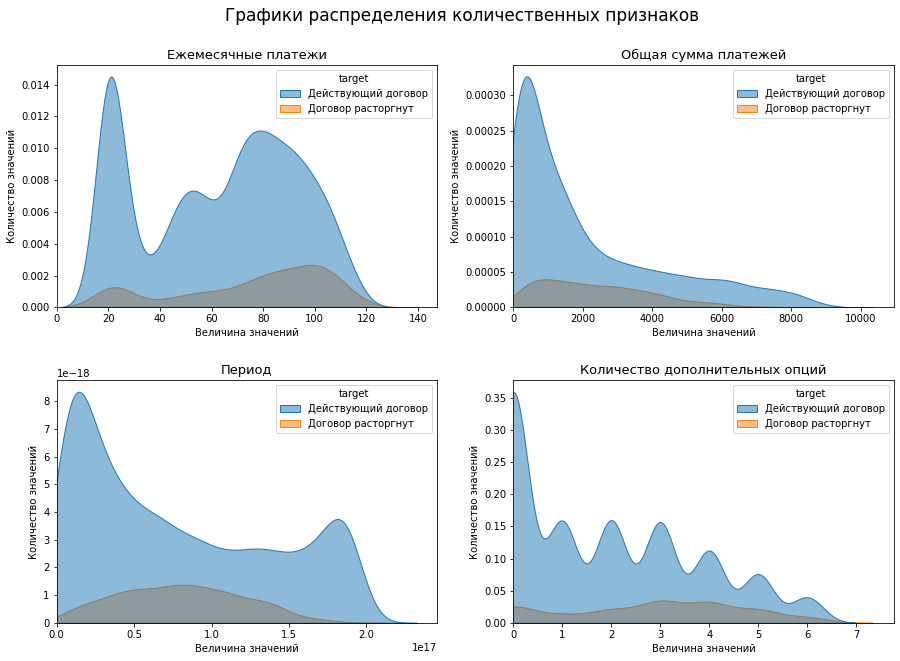

In [22]:
# Распределение количественных признаков
# Подготовим данные для визуализации

# Список столбцов с количественными данными
col_list = ['monthly_charges', 'total_charges', 'period', 'options']

# Список заголовков для столбцов с количественными данными
col_list_label = ['Ежемесячные платежи', 'Общая сумма платежей', 'Период', 'Количество дополнительных опций']

# Переменные для расположения графиков
x=2
y=2
z_list = list(range(5))
z_list.remove(0)

# Зададим параметры визуализации
fig, axes = plt.subplots(figsize=(15, 10))
plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.3)
plt.suptitle('Графики распределения количественных признаков', fontsize=17)

# Все подготовлено, применим цикл для построения графиков
for (l,t,z) in zip(col_list, col_list_label, z_list):
    plt.subplot(x, y, z)
    chart(df[l], t);

Графики показывающие распределение количественных признаков, позволяют сформулировать несколько тезисов.

* Ежемесячно большая часть клиентов платит либо около 20у.е либо от 70 до 110у.е. Формально, это две группы, которые платят либо меньше среднего, либо выше среднего. Возможно это связано с количеством доп. опций или с денежной политикой оператора в течении времени.

* Большее количество значений для общей суммы платежей находится в диапазоне до 1500у.е. Это может говорить о том, что те клиенты, которые пользовались услугами оператора долго, платили мало, а те кто платили много - пользовались недолго, в основном.

* Большая часть клиентов пользуется услугами оператора чуть менее года (10 месяцев приблизительно), так же есть некоторое количество прям постоянных клиентов, почти 6 лет (около 70 месяцев), их можно определить как группу, но их значительно меньше.

* Большая часть клиентов не использует дополнительные опции интернет-провайдера. Примерно равное количество подключает от 1 до 4 дополнительных опций, есть и те кто использует все, но их значительно меньше.

Отдельно рассмотрим клиентов расторгнувших договор:

* Расторгнувших договор больше при ежемеячных платежах выше среднего.

* Чем больше общая сумма платежей, тем меньше ушедших клиентов.

* Самый опасный период от 20 до 40 месяцев.

* Клиенты подключившую одну доп. опцию или все, уходят чуть реже, чем пользующиеся некоторыми или ни одной.

#### Распределение значений категориальных данных, изучение их связи с целевым признаком

Для лучшего восприятия нам понадобится список заголовков для каждого графика

In [23]:
cat_list_label = ['Тип оплаты', 'Безналичный расчет', 'Метод оплаты', 'Пол', 'Пенсионный возраст',
                'Брак', 'Еждевенцы', 'Подключение к интернет', 'Онлайн защита', 'Онлайн облако', 
                'Защита устройства', 'Выделенный саппорт', 'Стриминговое ТВ', 'Стриминговые фильмы', 'Несколько линий']

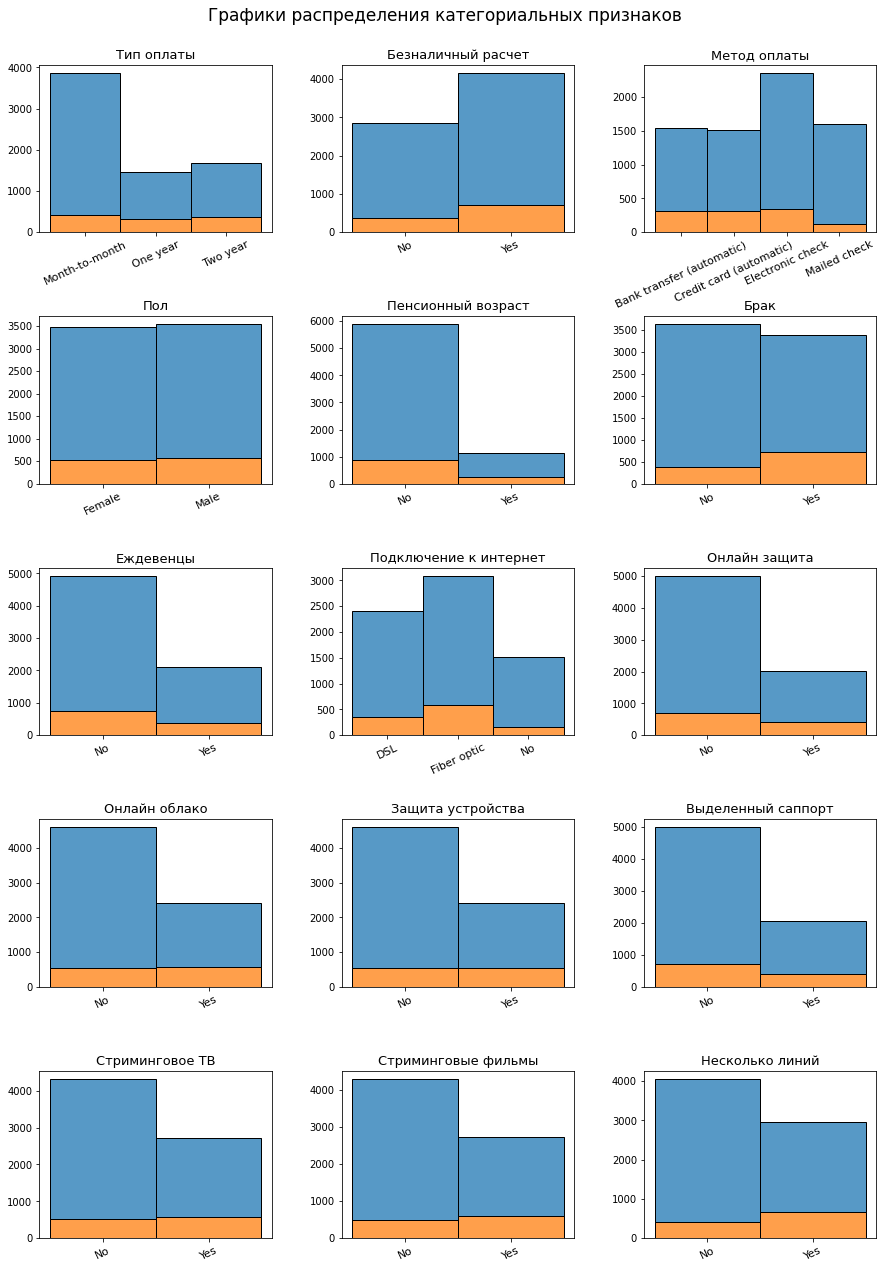

In [24]:
# Распределение категориальных признаков
# Переменные для определения количества и последовательности subplots
x=5
y=3
z_list = list(range(16))
z_list.remove(0)

# Параметры визуализации графиков
fig, ax = plt.subplots(figsize=(15, 20))
plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.5)
plt.suptitle('Графики распределения категориальных признаков', fontsize=17)

# Все подготовлено, применим цикл для построения графиков
for (l,t,z) in zip(cat_list, cat_list_label, z_list):
    plt.subplot(x, y, z)
    chart_cat_1(l,t);

Изучив распределение значений в категориальных признаках, можно выделить несколько тезисов:
* Большинство клиентов выбирают ежемесячный тип оплаты.
* Безналичным расчетом пользуются чуть чаще, чем наличным.
* Электронный чек, самый популярный способ оплаты услуг.
* Мужчин и женщин в выборке примерно поровну.
* Услугами оператора пользуется небольшое количество людей пенсионного возраста.
* Холостяков и людей в браке примерно поровну.
* Большая часть клиентов не имеет еждевенцев.
* Оптоволокно используют чаще, чем DSL, но пользователей устаревшей технологии все еще много.
* Клиенты чаще не пользуются дополнительными опциями, чем наоборот.

Отдельно рассмотрим значения для расторгнувших договор (обозначены оранжевым цветом на графике):
* Такие показатели как пол, тип оплаты, онлайн облако, защита устройства, стриминговые сервисы, демонстрируют отсутствие влияния на отток клиентов.
* Кленты пользующиеся безналчным расчетом, уходят чаще.
* Клиенты пользующиеся "бумажными квитанциями" уходят реже.
* Пенсионеры уходят реже, а клиенты в браке чаще.
* Клиенты не имеющие еждевенцев расторгают договор чаще.
* Клиенты не имеющие интернета уходят довольно редко.
* Клиенты пользующиеся файрволом и выделенной линией поддержки уходят реже.

#### Исследование корреляции признаков

Построим матрицу, при помощи интрумента фи-корреляции для смешанного набора признаков


interval columns not set, guessing: ['monthly_charges', 'total_charges', 'period', 'options']


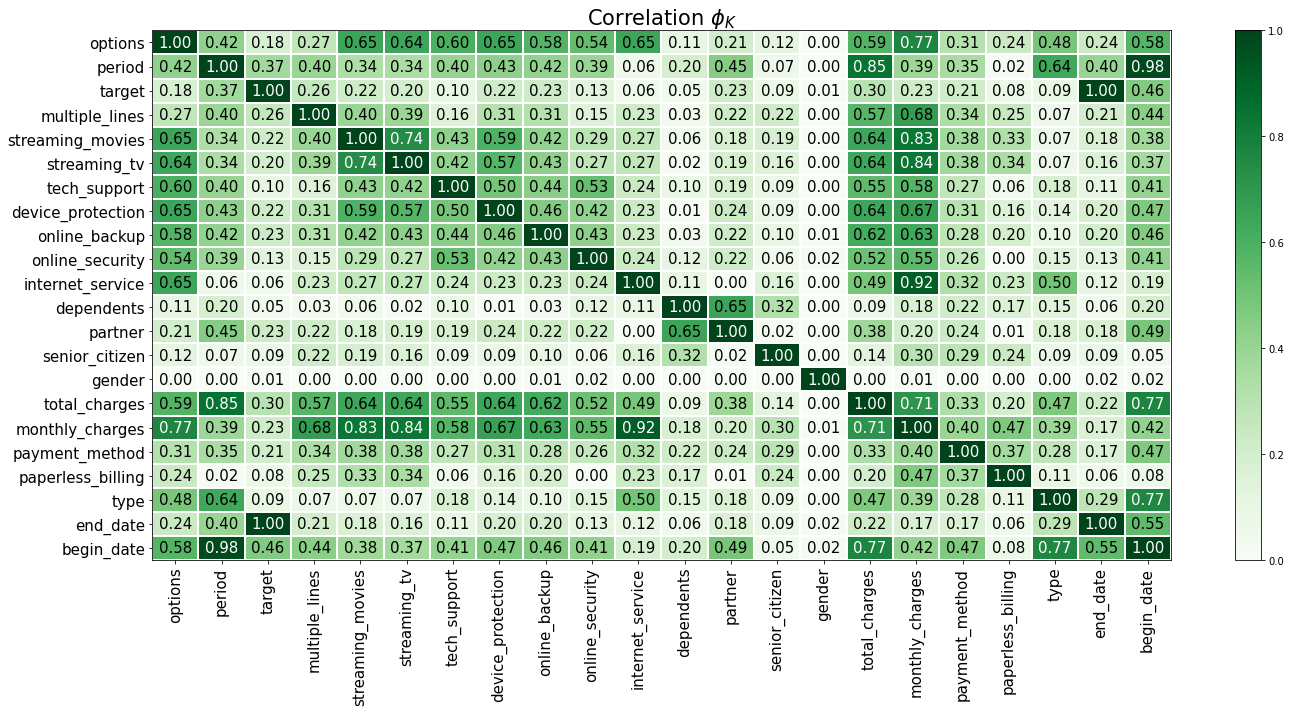

In [25]:
phik_overview = df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Сorrelation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout();

Изучив матрицу корреляций можно сформулировать несколько тезисов:

* Наблюдается значительная взаимосвязь между значениями целевого признака, периода и датами начала и окончания действия договора. Что вполне логично, ведь target и period сформированы на основании дат. Это надо учесть при обучении, чтобы не допустить утечки.

* Можно увидеть сильную связть между периодом и общей суммой платежей, закономерно, чем дольше пользуешься, тем больше платишь.

* Естественно есть сильная связь между ежемесячными платежами и общей суммой. Она из них состоит.

* Есть сильная связь между ежемесячным платежом и наличием интернет-подключения. Похоже это услуга занимает большую часть чека.

* Дополнительные опции так же имеют связь с платежами. Справедливо, их наличии и количество формирует финальную цену.

* Интересно что сами дополнительные опции имеют связь между собой, похоже что тот кто пользуется стриминговым ТВ, с высокой вероятностью будет пользоваться и стриминговыми фильмами.

* Пол клиента похоже не имеет никакого значения.

* Если клиент находится в браке, то чаще имеет еждевенцев. 

* Тип договора, имеет связь с периодом пользования услугами. 

* Тип договора имеет высокую связь с датой заключения контракта. Возможно тарифы в том виде, что есть в финале, появлялись не сразу или по разному продвигались в разные годы.

В целом все взаимосвязи логичны и предсказуемы. Однако визуализация позволяет подробно ознакомиться с ними и строить предположения о их происхождении, меньше вероятность что-то упустить.

#### Вывод блока "Анализ данных"

Изучив предоставленные данные можно сформулировать следующие тезисы:
* Данные содержащие информацию о времени, хорошо послужили для изучения и аналитики информации, но при обучении моделей, вероятнее всего вызовут утечки. Это надо учитывать.
* Внимательно надо отнестись и к колонкам с ежемесячным и общим платежом. Они аналогичны в каком-то смысле.
* Чем дороже стоят услуги, тем выше мотивация искать альтернативного оператора.
* Чем дольше клиент пользуется услугами оператора, тем меньше вероятность отказа.
* Дополнительные опции с одной стороны увеличивают стоимость, с другой могут и удерживать клиента.
* Пол клиента не имеет значения.
* Брак, наличие еждевенцев или возраст, могут оказывать влияние.

### Построение моделей

#### Подготовка данных к обучению

In [26]:
# Первым делом уберем столбцы, которую могу вызвать утечку данных
df.drop(['begin_date','end_date','total_charges','options'], axis=1, inplace=True);

In [27]:
# Целевой признак был изменен для лучшей визуализации ранее, верну как было
df["target"] = np.where(df["target"] == 'Действующий договор', 0, 1)

In [28]:
# Обозначим целевой признак
features = df.drop(['target'], axis=1)
target = df['target']

# Поделим выборку на обучающую и валидационную в соотношении 75:25
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                test_size=0.25, random_state=RND)

#### Кодирование и масштабирование

Проведем кодирование и масштабирование признаков для Обучающей и Тестовой выборок


In [29]:
# Сохраним выборки и списки заголовков в отдельные переменные
train = features_train.copy()
test = features_test.copy()

ohe_features_train = cat_list
num_features = ['monthly_charges', 'period']

# Обучаем энкодер
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train[ohe_features_train])

# Добавляем закодированные признаки в переменную
train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train[ohe_features_train])
train = train.drop(ohe_features_train, axis=1)

# Обучаем скалер
scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])

# Кодируем тестовую выборку
test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test[ohe_features_train])
test = test.drop(ohe_features_train, axis=1)

# Масштабируем тестовую выборку
test[num_features] = scaler.transform(test[num_features])

#### Логистическая регрессия

In [30]:
# Обозначим модель и сетку параметров
model = LogisticRegression(random_state=RND, class_weight='balanced')
grid_space = {'C': [10,100,1000],
             'max_iter': range(1,5)}

# Найдем оптимальные значения гиперпараметров и обучим модель
grid_logistic = GridSearchCV(model, grid_space, scoring=['roc_auc', 'accuracy'], 
                             refit='roc_auc', cv=5).fit(train, target_train)

# Изучим показатели
print('ROC AUC:', grid_logistic.best_score_)
print('Accuracy:', grid_logistic.cv_results_['mean_test_accuracy'][grid_logistic.best_index_])
print('Значение гиперпараметров:', grid_logistic.best_estimator_)

ROC AUC: 0.715082872487059
Accuracy: 0.6717893468348967
Значение гиперпараметров: LogisticRegression(C=1000, class_weight='balanced', max_iter=4,
                   random_state=240423)


#### Случайный лес

In [31]:
# Обозначим модель и сетку параметров
model = RandomForestClassifier(random_state=RND, class_weight='balanced')
grid_space={'n_estimators': [50,75,100],
            'max_depth': [5,6,7],
            'min_samples_leaf': [5,10],
            'min_samples_split': [5,10]
           }

# Найдем оптимальные значения гиперпараметров и обучим модель
grid_random_forest = GridSearchCV(model, grid_space, scoring=['roc_auc', 'accuracy'],
                                  refit='roc_auc', cv=5).fit(train, target_train)

# Изучим показатели
print('ROC AUC:', grid_random_forest.best_score_)
print('Accuracy:', grid_random_forest.cv_results_['mean_test_accuracy'][grid_random_forest.best_index_])
print('Значение гиперпараметров:', grid_random_forest.best_estimator_)

ROC AUC: 0.818793789994578
Accuracy: 0.7745556085146182
Значение гиперпараметров: RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=75,
                       random_state=240423)


#### CatBoostClassifier

In [32]:
# Обозначим модель и сетку параметров
model = CatBoostClassifier(random_state = RND, auto_class_weights='Balanced')
grid_space = {'verbose' : [0],
              'max_depth': range (5,10,15),
              'learning_rate': [0.1, 0.3, 0.5],
              'iterations': [100, 150, 200],
              'l2_leaf_reg': [9, 11]
             }

# Найдем оптимальные значения гиперпараметров и обучим модель
cat_boost = GridSearchCV(model, grid_space, scoring=['roc_auc', 'accuracy'], 
                         refit='roc_auc', cv=5).fit(train, target_train)

# Изучим показатели
print('ROC AUC:', cat_boost.best_score_)
print('Accuracy:', cat_boost.cv_results_['mean_test_accuracy'][cat_boost.best_index_])
print('Значение гиперпараметров:', cat_boost.best_params_)

ROC AUC: 0.9044224783756748
Accuracy: 0.8687919638119734
Значение гиперпараметров: {'iterations': 200, 'l2_leaf_reg': 11, 'learning_rate': 0.3, 'max_depth': 5, 'verbose': 0}


#### Вывод блока "Построение моделей"

К этапу обучения были обозначены следующие требования:

* Размер тестовой выборки должен быть 0.25
* Основная метрика ROC AUC, должна быть не меньше 0.85
* Для обучения должны быть использовано не менее трех моделей разных видов.
* В качестве дополнительной метрики используется Accuracy, требования к ее показателям отсутствуют.

Для работы с предоставленными данными были выбраны три модели: Логистическая регрессия, Случайный лес и CatBoostClassifier.
Перед обучением данные были масштабированы и кодированы при помощи OHE.
Все модели были обучные с автоматическом подбор гиперпараметров и применением кросс валидации.

Логистическая регрессия.\
Значения гиперпараметров: C=1000, max_iter=4\
Показатель ROC AUC: ~ 0.72\
Показатель Accuracy: ~ 0.67

Случайный лес. \
Значения гиперпараметров: max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=75\
Показатель ROC AUC: ~ 0.82\
Показатель Accuracy: ~ 0.77

CatBoostClassifier.\
Значения гиперпараметров: iterations=200, l2_leaf_reg=11, learning_rate=0.3, max_depth=5\
Показатель ROC AUC: ~ 0.90\
Показатель Accuracy: ~ 0.87

Исходя из условий задачи для проверки на тестовой выборке выбрана модель CatBoostClassifier.


### Проверка на тестовой выборке

In [33]:
prediction = cat_boost.best_estimator_.predict_proba(test)[:, 1]
print('ROC AUC:', roc_auc_score(target_test, prediction))
print('Accuracy:', accuracy_score(target_test, prediction.round()))

ROC AUC: 0.9081055854241338
Accuracy: 0.8822525597269625


Показатель ROC AUC на тестовой выборке ~ 0.91, это полностью удовлетворяет поставленной задаче.
Показатель Accuracy ~ 0.88.

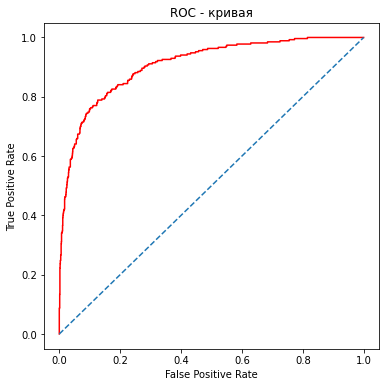

In [34]:
# Построим ROC - кривую
fpr, tpr, thresholds = roc_curve(target_test, prediction)
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr,  color='red')
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC - кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Показатель не идеальный, однако вполне удовлетворяет поставленной задаче.

#### График важности признаков

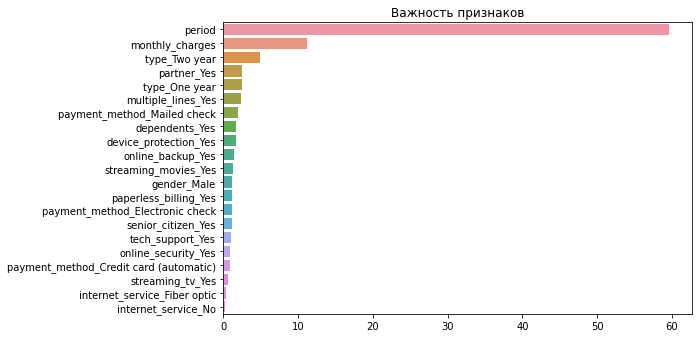

In [35]:
# Построим график важности признаков
plt.figure(figsize=(10, 5))

feature_importance = cat_boost.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, test.columns)), columns=['Value','Feature'])

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

plt.title('Важность признаков')
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.show();

Исходя из полученного графика, можно выделить самые влиятельные признаки:\
Период пользования услугами оператора, величина ежемесячного платежа, тип тарифа, наличие брака, тип платежа, метод оплаты.\
И самые не влиятельные признаки:\
Тип интернет подключения и наличие его в принципе, а так же некоторые дополнительные опции с ним связанные.

### Общий вывод

В ходе выполнения проекта:

* Данные были загружены, для предварительного ознакомления базовыми методами. Дополнительная информация была получена от тимлида во время вебинара.
* После предварительного ознакомления с данными, формулировки задачи, условий и требовании, была произведена подготовка данных, а именно:
1. Все данные объединены в один датасет и визуальное оформление датасета приведено к единообразию.
2. Типы данных назначены в соответствии со значениями.
3. Устранены появившиеся пропуски, появившиеся после объединения.
4. Сформирован целевой признак. Бинарное значение, на основании даты расторжения договора, клиент либо расторгнул договор, либо все еще пользуется услугами оператора.
5. Сформированы несколько дополнительных признаков, для удобстав анализа данных, общий срок действия договора, общее количество дополнительных услуг.
* Для анализа данных составлены графики, совмещающие в себе информацию как для общего количества клиентов, так и в отношении с целевым признаком. Это позволило комфортно изучить соотношение значений показателей для всех признаков.
* Так же ознакомился с корреляцией признаков при помощи интрумента фи-корреляции для смешанного набора признаков.
* После ознакомления, данные подготовлены к обучению в соответствии с поставленными условиями. Признаки, которые могли привести к утечке данных в выборки включены не были.
* Для кодирования категориальных признаков выбран энкодер OHE.
* Для обуения выбраны модели Логистической регрессии, Случайного леса и CatBoostClassifier.
* Для реализации подбора гиперпараметров и перекрестной валидации выбран GridSearchCV.
* Произведена проверка на тестовой выборке и построение графика для анализа влиятельности признаков.

В результате обучения самой эффективной моделью оказался CatBoostClassifier, который показал удовлетворительную метрику ROC AUK и на тренировочной и на тестовой выборках (0.90 и 0.91 соответственно), дополнительная метрика Accuracy так же является приемлемой. Стоит обратить внимание на признаки, которые имеют связь с целевым. Самые влиятельные это срок действия договора и цена. 

Построенная модель показала необходимые значения метрик, соответствует всем обозначенным условиям и может быть использована для выявления клиентов потенциально готовых отказаться от услуг компании.

## Отчет по выполнению проекта "Прогнозирование оттока клиентов для оператора связи"


# Описание цели проекта

Была поставлена задача по предоставленным данным обучить модель, котораая на основе имеющихся признаков сможет предсказывать клиентов, которые потенциально могут отказаться от услуг оператора.\
В качестве исходной информации использовалось несколько наборов данных, содержащих базовую информацию об видах и типах оказываемых услуг и некоторые персональные особенности клиентов.\
Так же обозначена ключевая метрика ROC AUC, показатель, которой должен быть не менее 0.85. В качестве дополниельно метрики использовалась Accuracy без требований к значению.

# Предварительный анализ и подготовка данных

Предварительный анализ данных позволил понять с какими данными предстоит работать и составить план выполнения проекта. Этот этап включает в себя несколько блоков. 

* Данные были объединены в один датасет, приведены к единообразию. Обработка пропусков в данном случае не потребовала синтезировать или выводить средние значения. Все пропуски являются по сути логическим отсутствием значения, соответствующим образом и были заполнены. После чего типы данных были приведены в соотвтествии с содержащимися значениями.

* После подготовки данных, были идентефицированы признаки, в разрезе выполнения работы все признаки поделены на три блока.
     1. Целевой признак - 'target'\
        Целевым признаком в этом проекте является факт расторжения договора. Изначально в данных в пригодном для работы виде он отсутствовал. Поэтому на осонове значения даты расторжения договора создан бинарный признак показывающий, расторгнут договор или является действующим.
     2. Количественные признаки.
     * Значение ежемесячных платежей - 'monthly_charges'
     * Значение суммы всех платежей -'total_charges'
     * Добвлане признак о сроке действия договора в днях. (Разница между датой заключения и датой окончания договора) - 'period'
     * Добален признак суммы количества дополнительных услуг для пользователей интернет - 'options'
     3. Категориальные признаки.
     * Тип оплаты - 'type'
     * Безналичный расчет - 'paperless_billing'
     * Метод оплаты - 'payment_method'
     * Пол - 'gender'
     * Пенсионный возраст - 'senior_citizen'
     * Брак - 'partner'
     * Еждевенцы - 'dependents'
     * Подключение к интернет - 'internet_service'
     * Онлайн защита - 'online_security'
     * Онлайн облако - 'online_backup'
     * Защита устройства - 'device_protection'
     * Выделенный саппорт - 'tech_support'
     * Стриминговое ТВ - 'streaming_tv'
     * Стриминговые фильмы - 'streaming_movies'
     * Несколько линий - 'multiple_lines'         

# Анализ данных

После того как данные подготовлены и признаки обозначены. Необходимо изучить какие собственно значения содержаться в признаках, как они взаимодействуют с целевым признаком и  друг с другом. Для исследования данных выбран метод визуализации при помощи графиков. Изучаем соотношение значений в общем и относительно клиентов расторгновших договор. Так как признаков немного, для каждого признака построен отдельный график. Для удобства восприятия использовалась группировка по типу признака. Это позволило сформировать представление о том, какое количство клиентов расторгли договор относительно общего количества в разрезе каждого признака.\
Так как мы имеем смешанный набор признаков. Для изучения корреляции отлично подошел интрумент фи-корреляции для смешанного набора признаков с визуализацией в виде матрицы. 

В сухом остатке анализ данных позволил выявить признаки, которые удобно было использовать для изучения данных, однако при обучении они могли вызвать утечку данных. Поэтому перед обучением из датасета были исключены столбцы содержащие дату начала и конца действия договора, общую сумму платежей и общее количество дополнительных опций. Так же был выявлен дисбаланс распределения значений.

Прочие данные местами имели повышенную корреляцию, однако были оставлены в связи с тем, что высокая корреляция между бинарными и категориальными признаками может быть из-за нелинейных взаимосвязей.

# Построение моделей

Для обучения было выбрано три различных вида моделей:
* Линейная регрессия
* Случайный лес
* CatBoostClassifier


* Датасет был разделен на обучающую и тестовую, в соотношении 75 к 25.
* Для кодировки категориальных значений использовался энкодер OHE.
* Для линейных моделей произведено масштабирование при помощи StandardScaler.
* Для устранения дисбаланса использовался параметр class_weight.
* Для подбора параметров и реализации кросс-валидации использовался GridSearchCV.
* Так же для всех моделей применено значение random_state = 240423.

Перечень используемых гиперпараметров для каждой модели:
1. Линейная регрессия.
* 'C' со значениями [10,100,1000]
* 'max_iter' в диапазоне (1,5)
 
Целевой метрики достичь не удалось.

2. Случайный лес.
* 'n_estimators'со значениями [50,75,100]
* 'max_depth' со значениями [5,6,7]
* 'min_samples_leaf' со значениями [5,10]
* 'min_samples_split' со значениями [5,10]

Целевой метрики достичь не удалось

3. CatBoostClassifier.
* 'max_depth': в диапазоне (5,10,15)
* 'learning_rate' со значениями [0.1, 0.3, 0.5]
* 'iterations' со значениями [100, 150, 200]
* 'l2_leaf_reg' со значениями [9, 11]

Целевая метрика достигнута.\
Значение целевой метрики ROC AUC ~ 0.90 при показателе дополнительной метрики Accuracy: ~ 0.87 получено при:\
'iterations': 200, 'l2_leaf_reg': 11, 'learning_rate': 0.3, 'max_depth': 5

Модель CatBoostClassifier так же была проверена на тестовой выборке и показала значение:\
ROC AUC: 0.91\
Accuracy: 0.88

Показатели целевой метрики полностью удовлетворяют поставленной задаче.\
Для наглядности построен график ROC-кривой.\
Для определения веса признаков построен график важности признаков.

# Вывод

Самым весомым оказался математически расчитанный признак, который содержал информацию о длительности контракта в днях. Его как и целевого признака изначально не было в данных. Получить их удалось только после проведения аналитического исследования исходной информации, это является основной сложностью данного проекта.

Ключевыми этапами проекта являются:
* Ознакомление с условиями и целью задчи.
* Предварительный анализ и подготовка данных.
* Анализ данных.
* Построение моделей.
* Проверка выбранной модели.
* Вывод.

Каждый из этапов не может существовать без предыдущего, следовательно все этапы не просто важны, они необходимы.
  
Составленный план позволил составить правильную последовательность действий и не потребовал корректировок в ходе выполнения работы. Проект полностью соответствует изначальному плану.

Благодаря комплексному подходу к анализу и использовании различных по своей сути моделей обучения, удалось получить результаты полностью удовлетворяющие поставленной задаче. При этом соблюдены все условия и требования предъявляемые к проекту. 